## Book Recommender System

#### Author: Andrew Tran

To complete this blog post, I used the following online sources as references for developing this:

[1] Book Recommendation Dataset:

Möbius, "Book Recommendation Dataset", Apr.-2023. [Online]. Available: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset. [Accessed: 25-Sep.-2023].

[2] Tutorial on Basics of ML Recommendation Systems:

M. Ahammad, "Movie Recommender Systems Using Neural Network," 2020. [Online]. Available: https://www. kaggle.com/code/mejbahahammad/movie-recommender-systems-using-neural-network. [Accessed: 25-Sep.-2023].

[3] Tutorial on Sample Visualizations for ML Recommendation Systems:

Great Learning Team, "Excerpts From a Masterclass on Movie Recommendation System," 22-Aug.-2022. Available: https://www.mygreatlearning.com/blog/masterclass-on-movie-recommendation-system/. [Accessed: 26-Sep.2023].

[4] Tutorial on Evalating ML Recommendation Systems:

A. Johannsdottir, "Implementing Your Own Recommmender Systems in Python", 28-Nov.-2019. Available: https://www.cambridgespark.com/info/recommender-systems-in-python. [Accessed: 27-Sep.2023].

## Data Preprocessing - Cleaning and Analytics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, pairwise_distances
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, dot
from tensorflow.keras.optimizers import Adam
plt.style.use("fivethirtyeight")

In [2]:
# Reading and displaying all of the initial datasets
books_df = pd.read_csv("datasets/Books.csv")
ratings_df = pd.read_csv("datasets/Ratings.csv")
users_df = pd.read_csv("datasets/Users.csv")

C:\Users\andre\AppData\Local\Temp\ipykernel_344\2730945584.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("datasets/Books.csv")


In [3]:
# Determining the shape of each of the initial datasets
books_df.shape, ratings_df.shape, users_df.shape

((271360, 8), (1149780, 3), (278858, 3))

In [4]:
# Getting a sample of each of the initial datasets through the seeing the 
# first 10 entries completely in each dataset
books_df.info(), ratings_df.info(), users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), obje

(None, None, None)

In [5]:
# Seeing each of the dataframes individually
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [6]:
ratings_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [7]:
users_df

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [8]:
# Remove unnecessary columns (before merging)
books_df.drop(columns=["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [9]:
# Merge the books and ratings dataframes to have one, inclusive dataframe
# with all book, user, and rating information
df = pd.merge(books_df, ratings_df, on="ISBN")
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385,0
...,...,...,...,...,...,...,...
1031131,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),276463,7
1031132,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,276579,4
1031133,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,276680,0
1031134,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,276680,0


In [10]:
# Figuring out the number of duplicated elements in the dataset
# (could be problematic if not resolved)
df.duplicated().sum()

0

In [11]:
# Figuring out the number of 'null'/'NaN' elements in the dataset 
# (if NaN filling is needed or not)
(df.isnull().sum() / df.shape[0]) * 100

ISBN                   0.000000
Book-Title             0.000000
Book-Author            0.000097
Year-Of-Publication    0.000000
Publisher              0.000194
User-ID                0.000000
Book-Rating            0.000000
dtype: float64

In [12]:
# Fill unknown and unformatted values with proper ones for readability and to
# improve data accuracy and relevance 
# Change types of columns to allow an easier time to parse
df["Year-Of-Publication"] = df["Year-Of-Publication"].astype(str)
df["Year-Of-Publication"] = df["Year-Of-Publication"].map(lambda entry: entry if entry.isnumeric() else df["Year-Of-Publication"].mode()[0])
df["Year-Of-Publication"] = df["Year-Of-Publication"].astype("int64")

df["Book-Author"].fillna("N/A", inplace=True)
df["Publisher"].fillna("N/A", inplace=True)

df["Book-Title"] = df["Book-Title"].astype(str)
df["Book-Author"] = df["Book-Author"].astype(str)
df["ISBN"] = df["ISBN"].astype(str)
df["Publisher"] = df["Publisher"].astype(str)

# Getting basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031136 non-null  object
 1   Book-Title           1031136 non-null  object
 2   Book-Author          1031136 non-null  object
 3   Year-Of-Publication  1031136 non-null  int64 
 4   Publisher            1031136 non-null  object
 5   User-ID              1031136 non-null  int64 
 6   Book-Rating          1031136 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 62.9+ MB


In [13]:
def report_basic_stats(dataframe: pd.DataFrame, type: str):
    global n_users, n_books
    n_users = dataframe["User-ID"].unique().shape[0]
    n_books = dataframe["ISBN"].unique().shape[0]
    n_ratings = len(dataframe["Book-Rating"])
    avg_num_ratings_per_user = n_ratings / n_users
    
    print("Number of Unique Book Users in This Dataset ({}):".format(type), n_users)
    print("Number of Unique Book Titles / ISBNs in This Dataset ({}):".format(type), n_books)
    print("Number of Total Ratings in This Dataset ({}):".format(type), n_ratings)
    print("Average Number of Book Ratings per User in This Dataset ({}):".format(type), round(avg_num_ratings_per_user, 3))

In [14]:
report_basic_stats(df, "Regular")

Number of Unique Book Users in This Dataset (Regular): 92106
Number of Unique Book Titles / ISBNs in This Dataset (Regular): 270151
Number of Total Ratings in This Dataset (Regular): 1031136
Average Number of Book Ratings per User in This Dataset (Regular): 11.195


In [15]:
# Filter the first 3000 Book-ISBNs in Dataset (keeps the data from
# becoming too long to visualize and compute within the ML model)
book_isbn_index = df.groupby("ISBN").count().sort_values(by="Book-Rating", ascending=False)[0:3000].index
df2 = df[df["ISBN"].isin(book_isbn_index)]
df2.count()

ISBN                   271456
Book-Title             271456
Book-Author            271456
Year-Of-Publication    271456
Publisher              271456
User-ID                271456
Book-Rating            271456
dtype: int64

In [16]:
# Filter the first 3000 Book-Users in Dataset (keeps the data from
# becoming too long to visualize and compute within the ML model)
book_users_index = df2.groupby("User-ID").count().sort_values(by="Book-Rating", ascending=False)[0:3000].index
df3 = df2[df2["User-ID"].isin(book_users_index)]
df3.count()

ISBN                   172071
Book-Title             172071
Book-Author            172071
Year-Of-Publication    172071
Publisher              172071
User-ID                172071
Book-Rating            172071
dtype: int64

In [17]:
# Make a separate dataframe for unique Book-ISBNs
book_isbns = df3["ISBN"].unique()
isbn_df = pd.DataFrame(data=book_isbns, columns=["Original-ISBN"])
isbn_df["New-ISBN"] = isbn_df.index + 1

In [18]:
# Make a separate dataframe for unique Book-Users (indicated by their IDs)
book_users = df3["User-ID"].unique()
users_df = pd.DataFrame(data=book_users, columns=["Original-User-ID"])
users_df["New-User-ID"] = users_df.index + 1

In [19]:
# Merge in new indices for Book-ISBN and Book-User-IDs that are modified
# from 1 to 3000 (accounts for scaling down of data)
cleaned_df = df3.merge(isbn_df, left_on="ISBN", right_on="Original-ISBN")
cleaned_df.drop(columns=["Original-ISBN"], axis=1, inplace=True)

cleaned_df = cleaned_df.merge(users_df, left_on="User-ID", right_on="Original-User-ID")
cleaned_df.drop(columns=["Original-User-ID"], axis=1, inplace=True)
cleaned_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,New-ISBN,New-User-ID
0,0440234743,The Testament,John Grisham,1999,Dell,277478,0,1,1
1,0971880107,Wild Animus,Rich Shapero,2004,Too Far,277478,0,3,1
2,0671888587,I'll Be Seeing You,Mary Higgins Clark,1994,Pocket,277478,0,9,1
3,0440225701,The Street Lawyer,JOHN GRISHAM,1999,Dell,277478,0,15,1
4,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,277478,0,30,1
...,...,...,...,...,...,...,...,...,...
172066,0767908171,A Short History of Nearly Everything,Bill Bryson,2003,Broadway,70999,0,2798,3000
172067,0385234104,Fatherhood,Bill Cosby,1986,Bantam Dell Pub Group,70999,0,2857,3000
172068,0425190641,Fire Ice: A Novel from the Numa Files (Kurt Au...,Clive Cussler,2003,Berkley Publishing Group,70999,0,2874,3000
172069,0553584375,No One to Trust,IRIS JOHANSEN,2003,Bantam,70999,0,2880,3000


In [20]:
cleaned_df_condensed_trends = cleaned_df.copy()
cleaned_df_condensed_trends.drop(labels=["ISBN", 
                                         "Book-Author",
                                         "Year-Of-Publication",
                                         "Publisher",
                                         "User-ID",
                                         "New-ISBN",
                                         "New-User-ID"], axis=1, inplace=True)
cleaned_df_condensed_trends_copy = cleaned_df_condensed_trends.copy()
cleaned_df_condensed_trends = pd.DataFrame(cleaned_df_condensed_trends_copy
                                           .groupby("Book-Title")["Book-Rating"]
                                           .mean())
cleaned_df_condensed_trends["Total-Num-Of-Ratings"] = pd.DataFrame(cleaned_df_condensed_trends_copy
                                                                   .groupby("Book-Title")["Book-Rating"]
                                                                   .count())
cleaned_df_condensed_trends.head()

,Book-Rating,Total-Num-Of-Ratings
Book-Title,,
10 Lb. Penalty,1.911765,34
16 Lighthouse Road,1.276596,47
1984,3.817460,126
1st to Die: A Novel,2.893891,311
2010: Odyssey Two,2.086207,58


C:\Users\andre\AppData\Local\Temp\ipykernel_344\177655821.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cleaned_df_condensed_trends.index,


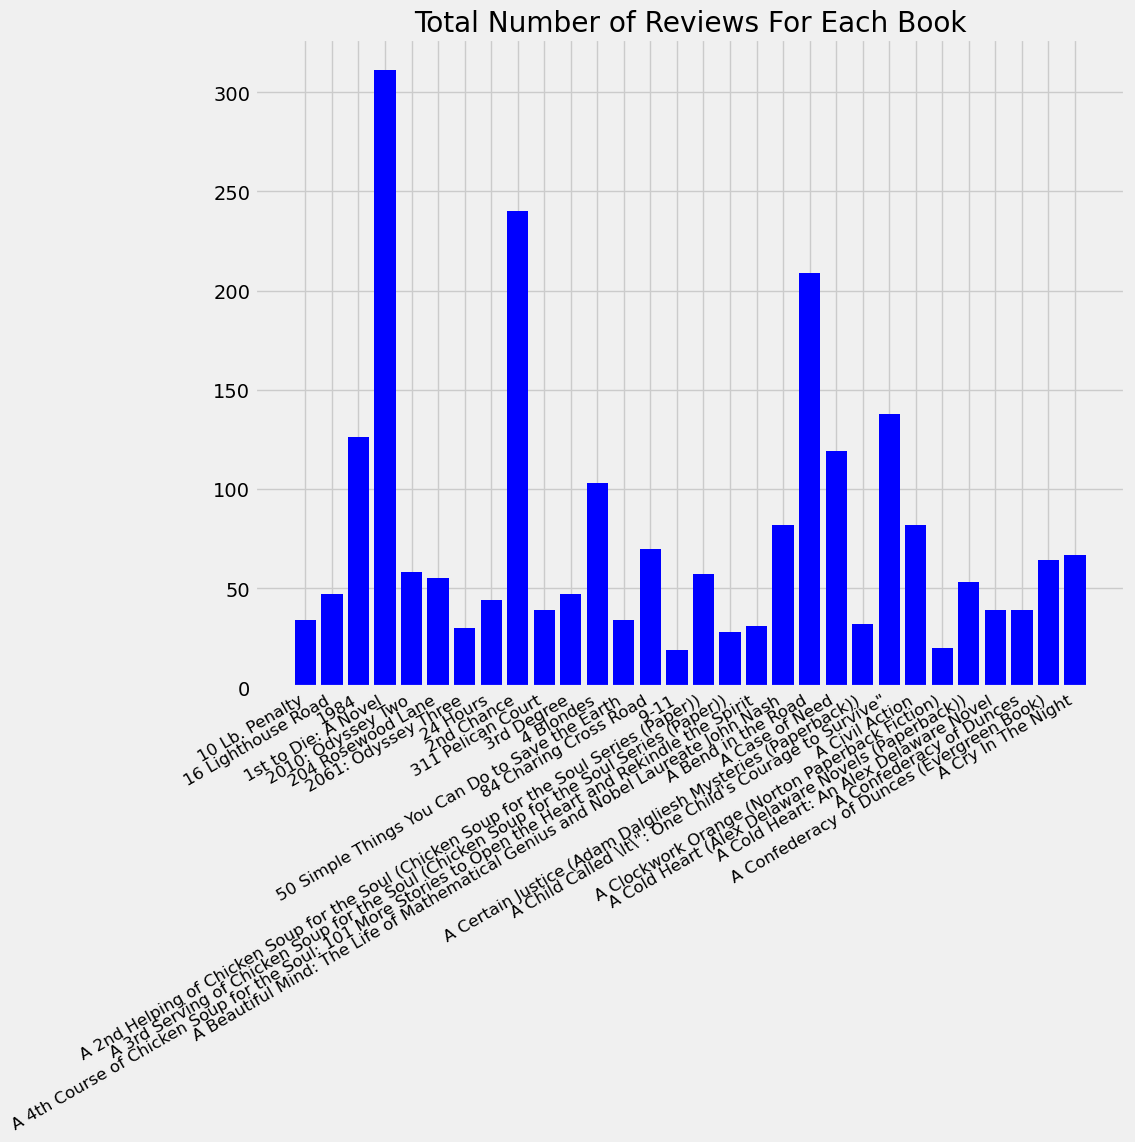

In [21]:
# Creating a bar graph describing number of reviews for first 30 books
plt.figure(figsize=(10, 8))
ax=plt.subplot()
ax.bar(cleaned_df_condensed_trends.head(30).index,
       cleaned_df_condensed_trends["Total-Num-Of-Ratings"].head(30), 
       color="b")
ax.set_xticklabels(cleaned_df_condensed_trends.index,
                   rotation=30,
                   fontsize="12",
                   horizontalalignment="right")
ax.set_title("Total Number of Reviews For Each Book")
plt.show()

In [22]:
# Calculate mean rating of all movies
# Check the popular, high-rating books (top-50) and unpopular, low-rating books (bottom-50)
cleaned_df_sorted_mean_rating = cleaned_df.copy().groupby("Book-Title")["Book-Rating"].mean().sort_values(ascending=False)
print("--------- Sorted by Mean On Average: ---------\n")
print("--------- TOP 50: ---------\n", cleaned_df_sorted_mean_rating.head(50), "\n\n--------- BOTTOM 50: ---------\n", cleaned_df_sorted_mean_rating.tail(50))

--------- Sorted by Mean On Average: ---------

--------- TOP 50: ---------
 Book-Title
Generation Golf. Eine Inspektion                                                                          9.000000
Novocento, Un Monologo                                                                                    9.000000
Io Non Ho Paura                                                                                           8.000000
Herr Lehmann.                                                                                             7.500000
L'Etranger (Collection Folio, 2)                                                                          6.777778
Griffin &amp; Sabine: An Extraordinary Correspondence                                                     6.000000
The Darwin Awards: Evolution in Action                                                                    5.653846
Harry Potter and the Sorcerer's Stone (Book 1)                                                            5

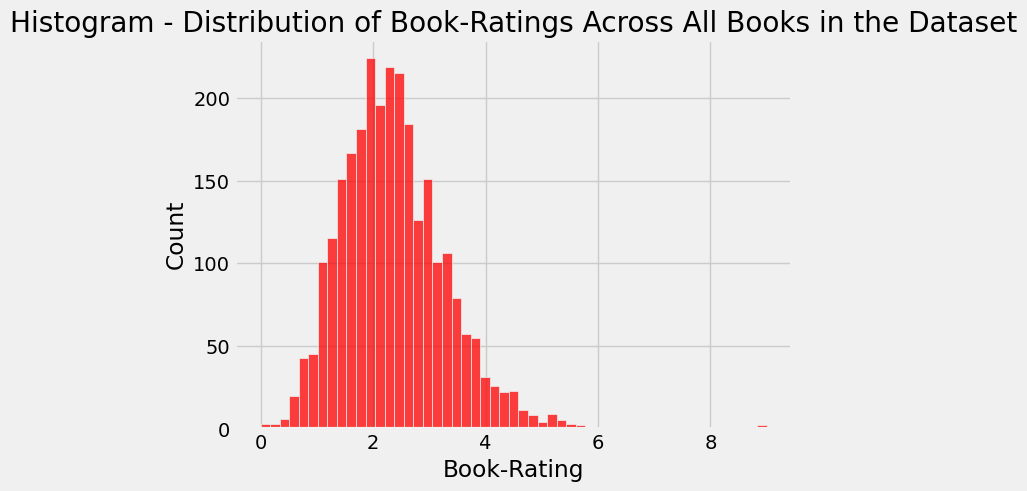

In [23]:
sns.histplot(pd.DataFrame(cleaned_df_sorted_mean_rating)["Book-Rating"], color="r")
plt.title("Histogram - Distribution of Book-Ratings Across All Books in the Dataset")
plt.show()

In [24]:
report_basic_stats(cleaned_df, "Reduced")

Number of Unique Book Users in This Dataset (Reduced): 3000
Number of Unique Book Titles / ISBNs in This Dataset (Reduced): 3000
Number of Total Ratings in This Dataset (Reduced): 172071
Average Number of Book Ratings per User in This Dataset (Reduced): 57.357


## Machine Learning - Model Training and Evaluation

In [25]:
# Configuring the ML Tensorflow Model by splitting the data 90% for testing,
# 5% for validation, and 5% for testing
X_train, X_test = train_test_split(cleaned_df, test_size=0.10, shuffle=True, random_state=2018)
X_val, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

In [26]:
# Outputting the shape of the new datasets
print("Shape of Training Set:", X_train.shape, "and Size of Training Set:", X_train.size)
print("Shape of Validation Set:", X_val.shape, "and Size of Validation Set:", X_val.size)
print("Shape of Test Set:", X_test.shape, "and Size of Testing Set:", X_test.size)

Shape of Training Set: (154863, 9) and Size of Training Set: 1393767
Shape of Validation Set: (8604, 9) and Size of Validation Set: 77436
Shape of Test Set: (8604, 9) and Size of Testing Set: 77436


In [27]:
X_train

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,New-ISBN,New-User-ID
159718,0515111279,The Cat Who Wasn't There,Lilian Jackson Braun,1994,Jove Books,254899,0,548,2474
33289,068480087X,POSTCARDS,Annie Proulx,1994,Scribner,273979,0,1043,235
47405,0451176464,Gerald's Game,Stephen King,2001,Signet Book,31826,10,1517,393
86465,0871136791,Cold Mountain,Charles Frazier,1997,Atlantic Monthly Press,55548,0,1186,949
130007,0553279378,I Know Why the Caged Bird Sings,MAYA ANGELOU,1983,Bantam,275922,7,1380,1646
...,...,...,...,...,...,...,...,...,...
115605,0679751602,Mama Makes Up Her Mind: And Other Dangers of S...,Bailey White,1994,Vintage Books USA,8067,0,803,1383
84745,0316284955,White Oleander : A Novel (Oprah's Book Club),Janet Fitch,2000,Back Bay Books,266865,9,957,924
80098,0446608955,A Walk to Remember,Nicholas Sparks,2000,Warner Books,236283,10,1164,846
60006,0446532452,The Wedding,Nicholas Sparks,2003,Warner Books,103811,0,1656,563


In [28]:
# Define my cost function (mean-squared error) for each dataset before the
# invokation of the ML algorithm
df_ratings_train = np.zeros((n_users, n_books))
for r in X_train.itertuples():
    df_ratings_train[r[9] - 1, r[8] - 1] = r[7]
print(df_ratings_train.shape)
df_ratings_train

(3000, 3000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
df_ratings_validation = np.zeros((n_users, n_books))
for r in X_val.itertuples():
    df_ratings_validation[r[9] - 1, r[8] - 1] = r[7]
print(df_ratings_validation.shape)
df_ratings_validation

(3000, 3000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
df_ratings_test = np.zeros((n_users, n_books))
for r in X_test.itertuples():
    df_ratings_test[r[9] - 1, r[8] - 1] = r[7]
print(df_ratings_test.shape)
df_ratings_test

(3000, 3000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
book_user_similarity = pairwise_distances(df_ratings_test, metric="cosine")
book_item_similarity = pairwise_distances(df_ratings_test.T, metric="cosine")

def perform_prediction_similarity_based(ratings, similiarity, pred_type="user"):
    if pred_type == "user":
        mean_user_rating = ratings.mean(axis=1)
        # You use np.newaxis so that the user_rating has the same format as ratings
        ratings_diff = (ratings - mean_user_rating[: np.newaxis])
        pred = mean_user_rating[: np.newaxis] + (similiarity.dot(ratings_diff) / np.array([np.abs(similiarity).sum(axis=1)]))
    elif pred_type == "item":
        pred = ratings.dot(similiarity) / np.array([np.abs(similiarity).sum(axis=1)])
    return pred

book_user_prediction = perform_prediction_similarity_based(df_ratings_train, book_user_similarity, pred_type="user")
book_item_prediction = perform_prediction_similarity_based(df_ratings_train, book_item_similarity, pred_type="item")

def compute_mean_square_error(predicted, actual):
    predicted = predicted[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(predicted, actual)

print("For Collaborative Filtering:")
print(f"Book User-Based Mean-Square-Error: {compute_mean_square_error(book_user_prediction, df_ratings_test)}")
print(f"Book Item-Based Mean-Square-Error: {compute_mean_square_error(book_item_prediction, df_ratings_test)}")

For Collaborative Filtering:
Book User-Based Mean-Square-Error: 63.24677594331707
Book Item-Based Mean-Square-Error: 62.514055485131145


In [32]:
def print_sparsity_stats(df: pd.DataFrame, type: str):
    print("-------------- Sparsity Stats for {}: --------------".format(type))
    df_sparsity = float(len(df.nonzero()[0]))
    df_sparsity /= (df.shape[0] * df.shape[1])
    df_sparsity *= 100
    print('Sparsity: {:4.2f}%'.format(df_sparsity))

In [33]:
print_sparsity_stats(df_ratings_train, "Train")
print_sparsity_stats(df_ratings_validation, "Validation")
print_sparsity_stats(df_ratings_test, "Test")

-------------- Sparsity Stats for Train: --------------
Sparsity: 0.53%
-------------- Sparsity Stats for Validation: --------------
Sparsity: 0.03%
-------------- Sparsity Stats for Test: --------------
Sparsity: 0.03%


In [34]:
# Apply the Input, Embeddings, and Dot Product on the Model
n_latent_fact = 1
user_input = Input(shape=[1], name="User")
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_fact, 
                           name="User_Embedding")(user_input)
user_vec = Flatten(name="Flatten_Users")(user_embedding)
book_input = Input(shape=[1], name="Book")
book_embedding = Embedding(input_dim=n_books + 1, 
                           output_dim=n_latent_fact, 
                           name="Book_Embedding")(book_input)
book_vec = Flatten(name="Flatten_Movies")(book_embedding)
dot_product = dot([book_vec, user_vec], axes=1)
model = Model(inputs=[user_input, book_input], outputs=dot_product)

# Compile the model and fit the datasets to it
model.compile(loss="mse",
              optimizer=Adam(learning_rate=0.0001),
              metrics=["mean_absolute_error"])

book_rec_history = model.fit(x=(X_train["New-User-ID"], X_train["New-ISBN"]), 
                             y=X_train["Book-Rating"],
                             epochs=150,
                             validation_data=([X_val["New-User-ID"], X_val["New-ISBN"]], X_val["Book-Rating"]),
                             use_multiprocessing=True)

Epoch 1/150
4840/4840 [==============================] - 8s 2ms/step - loss: 19.9812 - mean_absolute_error: 2.4194 - val_loss: 19.8000 - val_mean_absolute_error: 2.3963
Epoch 2/150
4840/4840 [==============================] - 7s 2ms/step - loss: 19.9809 - mean_absolute_error: 2.4194 - val_loss: 19.8000 - val_mean_absolute_error: 2.3963
Epoch 3/150
4840/4840 [==============================] - 8s 2ms/step - loss: 19.9804 - mean_absolute_error: 2.4195 - val_loss: 19.8000 - val_mean_absolute_error: 2.3965
Epoch 4/150
4840/4840 [==============================] - 6s 1ms/step - loss: 19.9795 - mean_absolute_error: 2.4196 - val_loss: 19.7999 - val_mean_absolute_error: 2.3967
Epoch 5/150
4840/4840 [==============================] - 6s 1ms/step - loss: 19.9783 - mean_absolute_error: 2.4198 - val_loss: 19.7996 - val_mean_absolute_error: 2.3969
Epoch 6/150
4840/4840 [==============================] - 7s 1ms/step - loss: 19.9767 - mean_absolute_error: 2.4200 - val_loss: 19.7991 - val_mean_absolute_

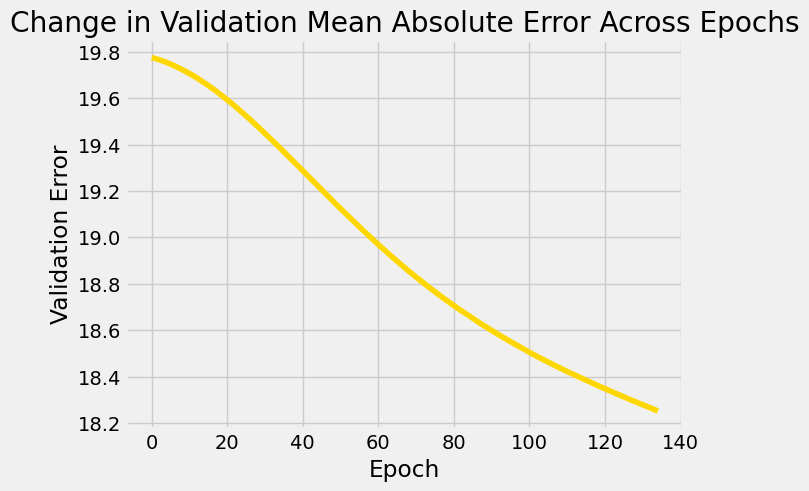

Minimum MSE: 18.252342224121094


In [35]:
# Plot the Validation Mean Absolute Error throughout the fitting of the model across epochs
pd.Series(book_rec_history.history["val_loss"][15:]).plot(logy=False, color="gold")
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
plt.title("Change in Validation Mean Absolute Error Across Epochs")
plt.show()

print("Minimum MSE:", min(book_rec_history.history["val_loss"]))

In [36]:
predicted_ratings = model.predict(x=(X_test["New-User-ID"], X_test["New-ISBN"])).flatten()

269/269 [==============================] - 0s 1ms/step


269/269 [==============================] - 0s 1ms/step - loss: 17.8935 - mean_absolute_error: 2.5685
Test Results:
Lost Score (When Compared to Test Set): 17.89
_______________________________________________
Average Precision Score (When Compared to Test Set): 31.27%)
_______________________________________________
Accuracy Score (When Compared to Test Set): 25.68%)
_______________________________________________
ROC AUC Score: 76.73%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.997032    0.033071  0.712459     0.515051      0.985604
recall        0.711127    0.823529  0.712459     0.767328      0.712459
f1-score      0.830152    0.063588  0.712459     0.446870      0.821065
support    8502.000000  102.000000  0.712459  8604.000000   8604.000000
_______________________________________________
Confusion Matrix: 
 [[6046 2456]
 [  18   84]]



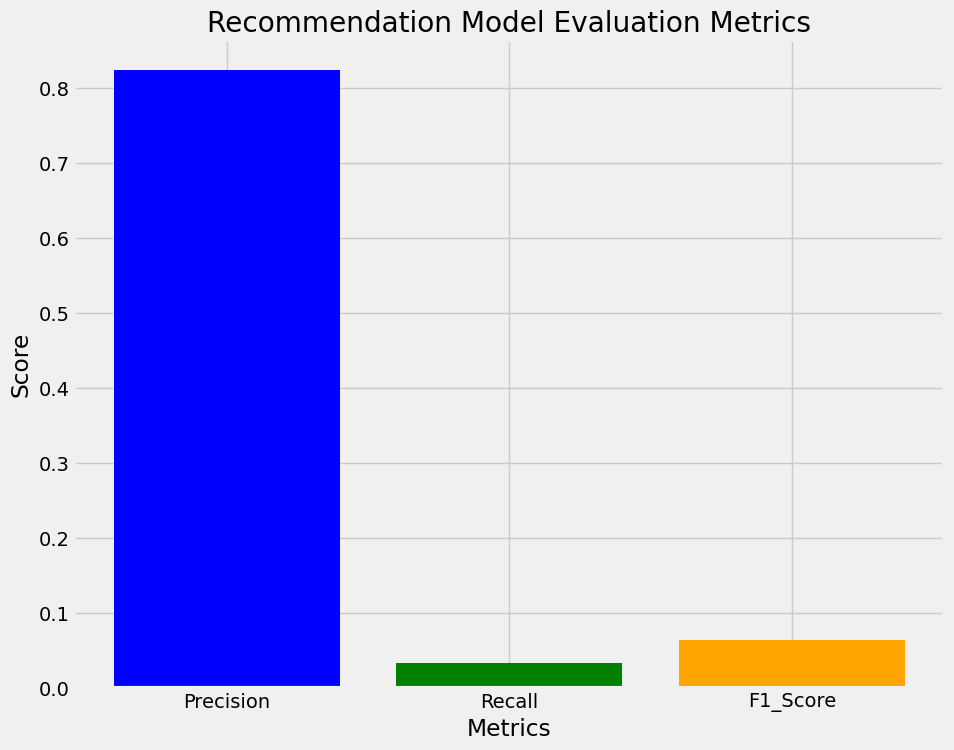

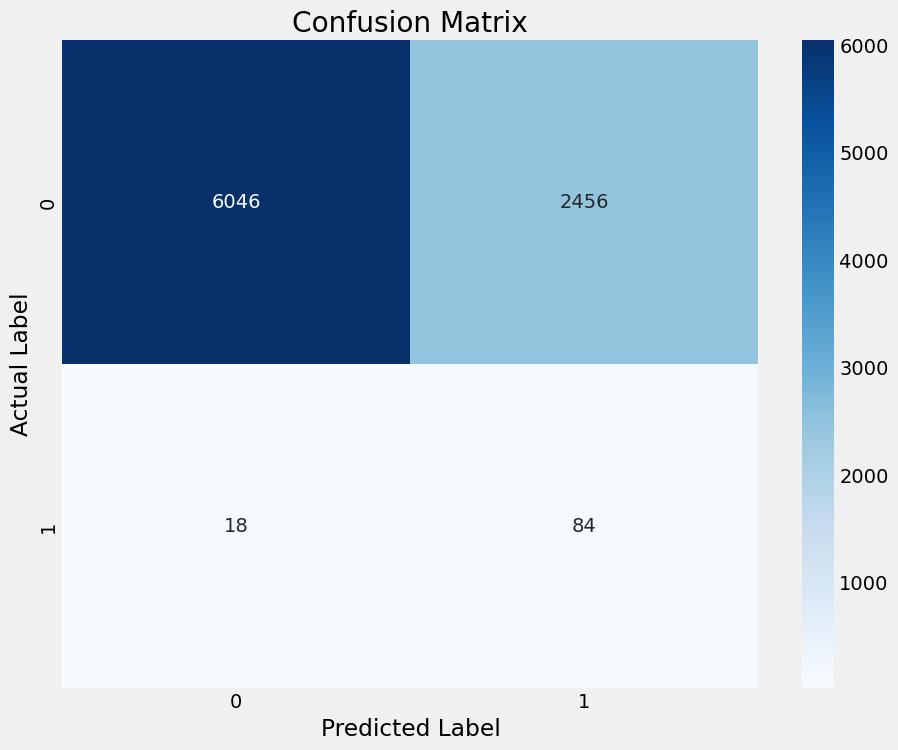

In [37]:
book_rec_history_model_loss, book_rec_history_model_accuracy = model.evaluate(x=(X_test["New-User-ID"], X_test["New-ISBN"]), y=X_test["Book-Rating"])
book_rec_history_model_accuracy /= 10

# Threshold the predicted ratings to binary recommendations (e.g., using a threshold of >= 5 for recommending book)
threshold = 5
predicted_labels_bin_classify = (predicted_ratings.copy() >= threshold).astype(int)
actual_labels_bin_classify = (X_test["Book-Rating"].copy() >= threshold).astype(int)

actual_ratings_str = predicted_labels_bin_classify.copy().astype(int)
predicted_ratings_str = actual_labels_bin_classify.copy().astype(int)
clf_report = pd.DataFrame(classification_report(y_true=actual_ratings_str, y_pred=predicted_ratings_str, output_dict=True, zero_division=0))

y_test_book_rating = predicted_labels_bin_classify
y_pred_book_rating = actual_labels_bin_classify

avg_precision_score = average_precision_score(y_true=actual_labels_bin_classify, y_score=predicted_labels_bin_classify)

print("Test Results:\n================================================")
print(f"Lost Score (When Compared to Test Set): {book_rec_history_model_loss:.2f}")
print("_______________________________________________")
print(f"Average Precision Score (When Compared to Test Set): {avg_precision_score * 100:.2f}%)")
print("_______________________________________________")
print(f"Accuracy Score (When Compared to Test Set): {book_rec_history_model_accuracy * 100:.2f}%)")
print("_______________________________________________")
print(f"ROC AUC Score: {roc_auc_score(y_test_book_rating, y_pred_book_rating) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_book_rating, y_pred_book_rating)}\n")

# Calculate Precision, Recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=actual_labels_bin_classify, y_pred=predicted_labels_bin_classify, average='binary')
model_performance_metrics: [str] = ["Precision", "Recall", "F1_Score"]
model_performance_metrics_values: [float] = [precision, recall, f1_score]

plt.figure(figsize=(10, 8))
plt.bar(model_performance_metrics, model_performance_metrics_values, color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Recommendation Model Evaluation Metrics')
plt.show()

# Create the confusion matrix
conf_mat = confusion_matrix(y_test_book_rating, y_pred_book_rating)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()